<a href="https://colab.research.google.com/github/RaviChandraVeeramachaneni/fastbook_myexperiments/blob/main/chapter_4/chap_4_mnist_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jul  7 07:50:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 5.1MB/s 
     |████████████████████████████████| 1.2MB 56.0MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 194kB 65.5MB/s 
     |████████████████████████████████| 61kB 10.6MB/s 
     |████████████████████████████████| 61kB 10.7MB/s 
Mounted at /content/gdrive


In [5]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

### Downloading the MNIST Dataset

In [6]:
path = untar_data(URLs.MNIST_SAMPLE)
path

Path('/root/.fastai/data/mnist_sample')

In [7]:
Path.BASE_PATH = path

### View the list of downloaded files using ls() from fastai lib

In [8]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

### What's inside a Train set

In [9]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

#### *Check Step: 2 cells: Checking the dataset whether we have everything right for 2 folders 3's & 7's - Not necessary for the actual baseline.*

In [10]:
threes = (path/'train'/'3').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [11]:
sevens = (path/'train'/'7').ls().sorted()
sevens

(#6265) [Path('train/7/10002.png'),Path('train/7/1001.png'),Path('train/7/10014.png'),Path('train/7/10019.png'),Path('train/7/10039.png'),Path('train/7/10046.png'),Path('train/7/10050.png'),Path('train/7/10063.png'),Path('train/7/10077.png'),Path('train/7/10086.png')...]

### Checking an image: 2 cells: 3 & 7 

In [12]:
img3_path = threes[1]
img3 = Image.open(img3_path)
img3

In [13]:
img7_path = sevens[5]
img7 = Image.open(img7_path)
img7

In [14]:
type(img7)

PIL.PngImagePlugin.PngImageFile

#### Image under the hood in a computer. 
    - Represting the image in a Numpy array in the form of rows & cols



In [15]:
array(img3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [16]:
type(array(img3))

numpy.ndarray

In [17]:
np.ndim(array(img3))

2

#### Image under the hood in a computer.
    - Represting the image in a PyTorch tensor in the form of rows & cols

In [18]:
tensor(img3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [19]:
type(tensor(img3))

torch.Tensor

In [20]:
tensor(img3).ndim

2

### Importing Pandas lib

### Check the array output using some cool functions from Pandas & color coding it check the results.

In [21]:
img3_t = tensor(img3)
df = pd.DataFrame(img3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## Simple Baseline approach for classifying the Images

### Step1: Calculating average of pixel values for each of our two groups
    - To do this we need to stack all the relative images using tensors & simple python lists

In [22]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

In [23]:
type(seven_tensors)

list

### Check one of the image using fastai show_image function

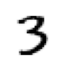

In [24]:
show_image(three_tensors[1])

### Stacking list of image tensors to create a rank-3 tensor which will allow us take the mean. 

In [25]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [26]:
type(stacked_sevens)

torch.Tensor

### Rank of a tensor

In [27]:
stacked_sevens.ndim

3

### Shape of a tensor

In [28]:
len(stacked_threes.shape)

3

### Calculating the mean of the image tensors along dimension-0 of our stacked rank-3 tensor for Image 3
    - for every pixel position, this will compute the average of that pixel over all the images.

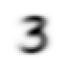

In [29]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

### The result is a 2-dimensional tensor or a ideal image of 3 in this case.

In [30]:
mean3.ndim

2

In [31]:
type(mean3)

torch.Tensor

### Calculating the mean of the image tensors along dimension-0 of our stacked rank-3 tensor for Image 7
    - for every pixel position, this will compute the average of that pixel over all the images.

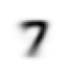

In [32]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

### Pick any 3 from the stacked 3's

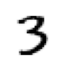

In [33]:
any_3 = stacked_threes[1]
show_image(any_3)

### Using L1 norm
    - To calculate the difference between the image to classify vs the ideal image.

#### Computing: L1 norm & L2 norm for a 3 & 7 using ideal 3 just to check the difference.
---
#### Result: The result would be that the difference of any 7 and a ideal 3 is very far & in case of any 3 it's very close in both L1 & L2.

In [34]:
dist_3_abs = (any_3 - mean3).abs().mean()
dist_3_sqr = ((any_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [35]:
dist_7_abs = (any_3 - mean7).abs().mean()
dist_7_sqr = ((any_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

### Checking the loss in the above cases using PyTorch functions.
    - The above models are also available directly in PyTorch in torch.nn.functional package
    - These models are by default imported in fastai as F as recommended by PyTorch lib.

In [36]:
F.l1_loss(any_3.float(),mean7), F.mse_loss(any_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### Computing the metrics/Using the created model to test the quality of our model with validation set

#### Stacking the images of 3's & 7's from validation set

In [37]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_3_tens.shape

torch.Size([1010, 28, 28])

In [38]:
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_7_tens.shape

torch.Size([1028, 28, 28])

#### function to determine the distance betweeb two tensors

In [39]:
def mnist_distance(a,b): 
    return (a-b).abs().mean((-1,-2))

#### Test the function by passing any image of 3 & a ideal 3

In [40]:
mnist_distance(any_3, mean3)

tensor(0.1114)

#### Compute: Distance to ideal 3 for every image to get overall accuracy.
---
 - Result: Rank-1 tesnor with distance of every single image as a vector.

In [41]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1463, 0.1076, 0.1296,  ..., 0.1776, 0.1209, 0.1531]),
 torch.Size([1010]))

#### Checking the shape stacked 3's in validation set 
---
 - Result: Mean3 value is bradcasted & subtarcted from each tensor in the valid_3_tens

In [42]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

#### function to determine whether given image is 3 or not.

In [43]:
def is_3(x): 
    return mnist_distance(x,mean3) < mnist_distance(x,mean7)

#### Test the function with a sample 3 image

In [44]:
is_3(any_3), is_3(any_3).float()

(tensor(True), tensor(1.))

#### Testing the full validation set of 3's using broadcasting technique

In [45]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

#### Calculate the accuracy for each of the 3s and 7s by taking the average of that function for all 3s and its inverse for all 7s

In [46]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

In [49]:
print(f'Accuracy of a given image being a 3 is {accuracy_3s}')

Accuracy of a given image being a 3 is 0.9168316721916199


In [50]:
print(f'Accuracy of a given image being a 7 is {accuracy_7s}')

Accuracy of a given image being a 7 is 0.9854085445404053


In [51]:
print(f'The overall accuracy of a given image being either a 3 or 7 is {(accuracy_3s+accuracy_7s)/2}')

The overall accuracy of a given image being either a 3 or 7 is 0.951120138168335
